In [1]:
import sys

import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint

In [2]:
sys.path.append("../")
sys.path.append("../LOCOinPython/")
sys.path.append("../Tracking_with_imperfections/")

In [3]:
from utils import apply_kicks, get_optics, read_tracking_file, plot_optics, plot_dynap, create_err_table, match_optics, correct_orbit, get_ptc_optics

In [4]:
from LOCOinPython.file_loader.structure_loader import read_structure
from LOCOinPython.numerical_model.orbit_correction import OrbitCorrectionSVD
from LOCOinPython.numerical_model.response_matrix import run_madx
from LOCOinPython.numerical_model.lattice_correction import LatticeCorrection

# Structure loading

In [5]:
file = "structures/Ring_DD.seq"
structure = read_structure(file)

file = "structures/Ring_DD_nosext.seq"
structure_nosext = read_structure(file)

Structure in the JSON format already exists
Structure in the JSON format already exists


# Ideal structure

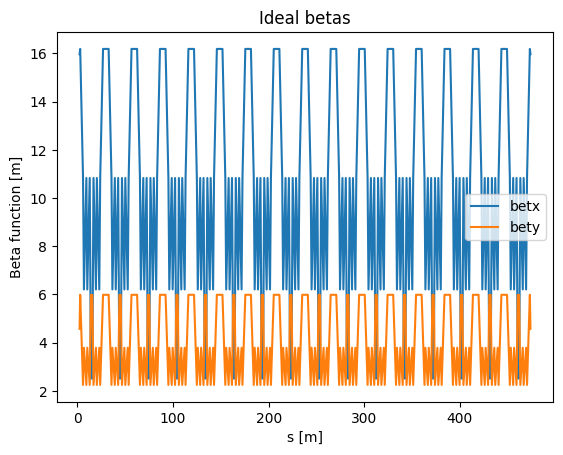

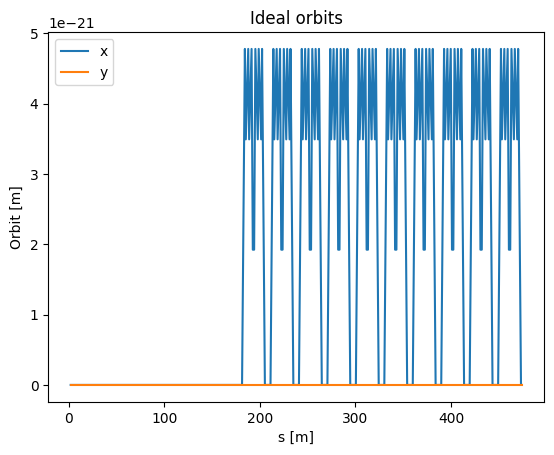

In [23]:
init_optics = get_optics(structure)
plot_optics(init_optics, params_to_show="beta", title="Ideal betas")
plt.show()

plot_optics(init_optics, params_to_show="orbit", title="Ideal orbits")
plt.show()

 21%|██████████████▎                                                      | 500009/2407417 [00:01<00:05, 346343.82it/s]
1799it [00:00, 390597.00it/s]


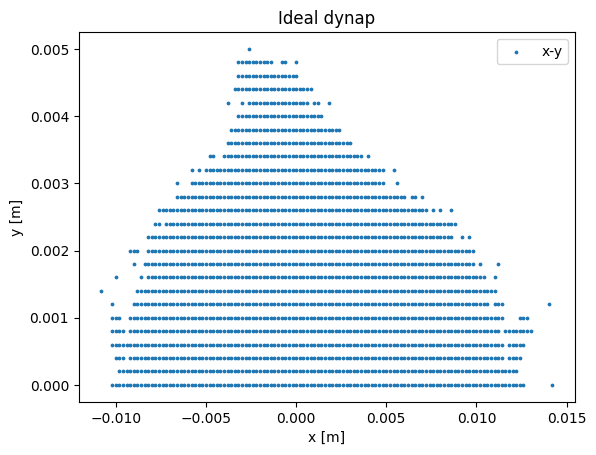

In [7]:
params = {"x": "m",
          "y": "m"}
tab_ideal = read_tracking_file("tracking_data/tracking_skif_xy_1000one.txt", unlost_only=True)
plot_dynap(tab_ideal, params, title="Ideal dynap", plot_name="x-y")
plt.show()

# Elements definition

In [29]:
elems_with_errs = [i for i in structure["elements"] if structure["elements"][i]["type"] not in ["monitor", "marker", "multipole"]]
hcorrs = {i: {"type": "hkicker"} for i in structure["elements"] if structure["elements"][i]["type"] in ["hkicker"]}
vcorrs = {i: {"type": "vkicker"} for i in structure["elements"] if structure["elements"][i]["type"] in ["vkicker"]}
corrs = {"hkicker": hcorrs, "vkicker": vcorrs}
quads = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["quadrupole"]]
bpms = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["monitor"]]
mult_quads = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["multipole"] and i.endswith(".cg")]
mult_skew_quads = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["multipole"] and i.endswith(".cc")]

# elems_for_matching = {quad: "k1" for quad in quads}
# elems_for_matching.update({corr: "kick" for corr in hcorrs})
# elems_for_matching.update({corr: "kick" for corr in vcorrs})

elems_for_matching = {quad: "k1" for quad in quads + mult_quads}
elems_for_matching.update({skew_quad: "k1s" for skew_quad in mult_skew_quads})

structure["kick"] = corrs
structure["kick_total"] = corrs
print(len(elems_with_errs))

1939


In [30]:
align_errs = create_err_table(["dx", "dy", "ds", "dpsi", "dphi", "dtheta"], elems_with_errs, seed=42)
# align_errs = create_err_table(["dx", "dy", "dpsi"], elems_with_errs, seed=1)

# Optics with all kind imperfections, sextupoles off

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:38<00:00,  6.44s/it]


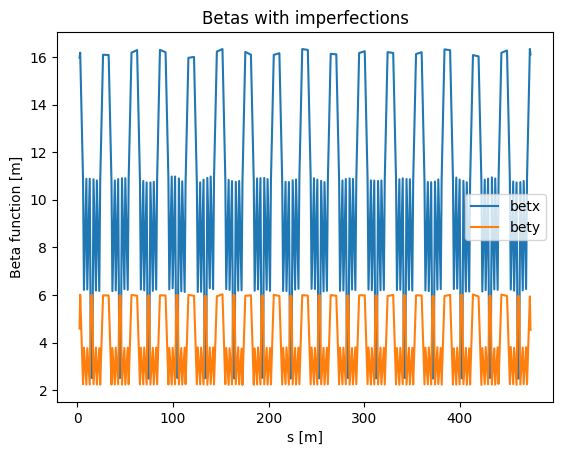

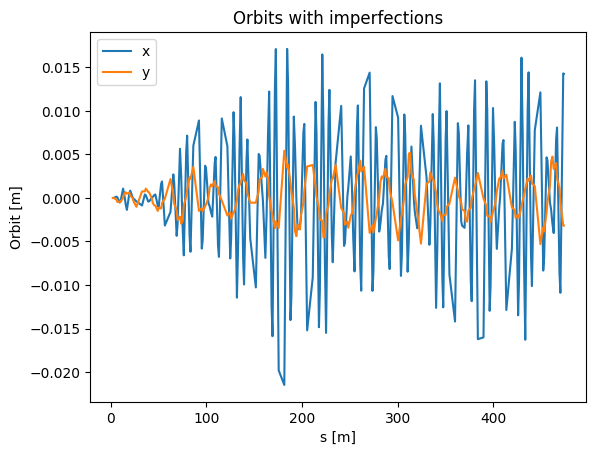

In [9]:
interim_optics_nosext = get_optics(structure_nosext, aligns=align_errs, verbose=True)
plot_optics(interim_optics_nosext, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_nosext, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

 16%|███████████▎                                                         | 500009/3063646 [00:01<00:07, 341014.39it/s]
2it [00:00, 603.15it/s]


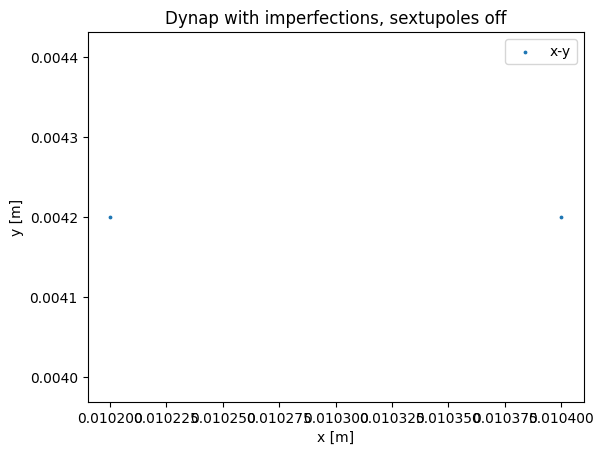

In [11]:
params = {"x": "m",
          "y": "m"}
tab_err = read_tracking_file("tracking_data/tracking_xy_nosext_norad_1000one.txt", unlost_only=True)
plot_dynap(tab_err, params, title="Dynap with imperfections, sextupoles off", plot_name="x-y")
plt.show()

## Orbit correction with LOCO

In [13]:
orm, tunes = run_madx(structure_nosext, {}, kick_value=0.00001)
total_hkicker = len(hcorrs)
total_vkicker = len(vcorrs)
total_bpms = len(structure["bpm_total"])
hkicker_matrix = pd.DataFrame(orm[:, :total_hkicker], columns=list(corrs["hkicker"]))
vkicker_matrix = pd.DataFrame(orm[:, total_hkicker:(total_hkicker+total_vkicker)], columns=list(corrs["vkicker"]))
dispersion = pd.DataFrame(orm[:, -1], columns=["dispersion"])
orm = pd.concat([hkicker_matrix, vkicker_matrix, dispersion], axis=1, keys=("hkicker", "vkicker", "dispersion"))
orm.set_axis(2 * structure["bpm_total"], axis=0, copy=False)

0:01:20.221639


hkicker                                                 
            ms1.kic3 ma1.cma1.cx ma1.bma1.cx  ma1.kic4 ma1.sfa1.cx   
ms1.pki2  -11.570944   -7.952544    0.575773  8.482735   10.684579  \
ma1.pka1  -11.564615   -8.260326    0.523477  8.647138   10.931898   
ma1.pkb1   10.950196    8.036437    0.671385 -5.873049   -7.780635   
ma1.pkc1    7.949428    5.870818    0.581562 -4.088879   -5.714042   
ma1.pkd1  -11.668931   -8.382734   -0.259466  7.008723    9.295345   
...              ...         ...         ...       ...         ...   
ma16.pkd4   0.000000    0.000000    0.000000  0.000000    0.000000   
ma16.pkc4   0.000000    0.000000    0.000000  0.000000    0.000000   
ma16.pkb2   0.000000    0.000000    0.000000  0.000000    0.000000   
ma16.pka2   0.000000    0.000000    0.000000  0.000000    0.000000   
ms1.pki1    0.000000    0.000000    0.000000  0.000000    0.000000   

                                                                       ...   
          ma1.sda1.cx ma1.sdb1.cx ma1.sfb1.cx ma1.sdc1.cx ma1.sdd1.cx  ...   
ms1.pki2     6.230281   -7.104742  -11.600400   -7.071729    6.368073  ...  \
ma1.pka1     6.408782   -7.120233  -11.677424   -7.152266    6.274903  ...   
ma1.pkb1    -4.376426    5.777755    9.188358    5.447798   -5.754475  ...   
ma1.pkc1    -3.590407    4.414339    7.098352    4.260676   -4.232157  ...   
ma1.pkd1     5.807644   -4.548117   -7.825325   -4.379269    5.778568  ...   
...               ...         ...         ...         ...         ...  ...   
ma16.pkd4    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
ma16.pkc4    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
ma16.pkb2    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
ma16.pka2    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
ms1.pki1     0.000000    0.000000    0.000000    0.000000    0.000000  ...   

               vkicker                                                       
          ma16.sdd2.cy ma16.sdc2.cy ma16.sfb2.cy ma16.cbb1.cy ma16.sdb2.cy   
ms1.pki2      0.000000     0.000000     0.000000     0.000000     0.000000  \
ma1.pka1      0.000000     0.000000     0.000000     0.000000     0.000000   
ma1.pkb1      0.000000     0.000000     0.000000     0.000000     0.000000   
ma1.pkc1      0.000000     0.000000     0.000000     0.000000     0.000000   
ma1.pkd1      0.000000     0.000000     0.000000     0.000000     0.000000   
...                ...          ...          ...          ...          ...   
ma16.pkd4    -1.321391    -2.036817    -1.905046    -2.232600    -2.572318   
ma16.pkc4     0.492254    -0.575428    -1.330853    -2.379635    -3.154050   
ma16.pkb2     1.658716     0.896248    -0.148263    -0.878319    -1.313043   
ma16.pka2     4.646851     3.768326     1.507892     0.706291     0.452999   
ms1.pki1      4.370511     3.718830     1.685256     1.103998     0.999695   

                                                                 dispersion  
          ma16.sda2.cy ma16.sfa2.cy ma16.cbc1.cy ma16.cma2.cy    dispersion  
ms1.pki2      0.000000     0.000000     0.000000     0.000000 -2.273011e-12  
ma1.pka1      0.000000     0.000000     0.000000     0.000000 -2.273361e-12  
ma1.pkb1      0.000000     0.000000     0.000000     0.000000  5.066535e-02  
ma1.pkc1      0.000000     0.000000     0.000000     0.000000  3.702794e-02  
ma1.pkd1      0.000000     0.000000     0.000000     0.000000  5.066535e-02  
...                ...          ...          ...          ...           ...  
ma16.pkd4    -1.958027    -0.713314     0.379232     1.301722  0.000000e+00  
ma16.pkc4    -3.812901    -2.200624    -1.975409    -1.816273  0.000000e+00  
ma16.pkb2    -2.029820    -1.857023    -2.758784    -3.291003  0.000000e+00  
ma16.pka2    -0.888274    -1.660236    -4.776474    -7.466557  0.000000e+00  
ms1.pki1     -0.169238    -1.069692    -3.700418    -5.967213  0.000000e+00  

[452 rows x 709 columns]

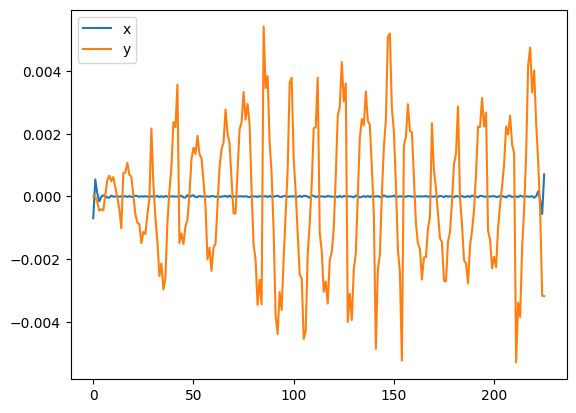

In [36]:
corrs_ = {"hkicker": list(corrs["hkicker"]), "vkicker": list(corrs["vkicker"])}
OrbitCorrectionSVD.SVD_CUTOFF = 1e-3
orbit_correction = OrbitCorrectionSVD(None)
orbit_correction.set_orm(orm)
orbit_correction.set_correctors(corrs_)

kicks, orb = orbit_correction.find_kicks(interim_optics_nosext["x"], interim_optics_nosext["y"], "x")
plt.plot(orb[:total_bpms], label='x')
plt.plot(orb[total_bpms:], label='y')
plt.legend()
plt.show()

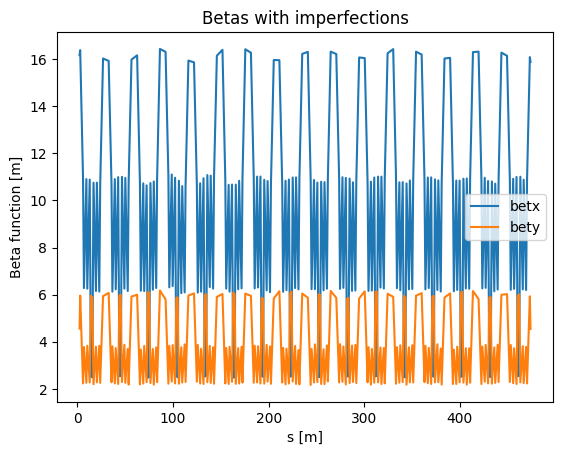

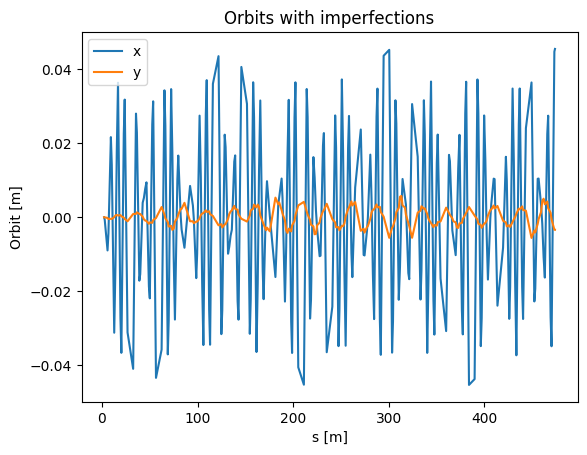

In [37]:
interim_optics_nosext_corrected_orb = get_optics(structure_nosext, imperfections_file="D:/PycharmProjects/SKIF-Lattice-Analysis/imperfections_tables/imperfections_all_aligns.txt", kicks_corrs=kicks, verbose=True)
plot_optics(interim_optics_nosext_corrected_orb, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_nosext_corrected_orb, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

## Orbit correction with MAD-X funcs

In [21]:
correct_orbit(structure_nosext, "D:/PycharmProjects/SKIF-Lattice-Analysis/imperfections_tables/imperfections_all_aligns.txt", None, None, verbose=True)
# correct_orbit(structure_nosext, aligns=align_errs, ncorrs=64, plane="y", verbose=True)
interim_optics_nosext_corr_orbit = get_optics(structure_nosext, imperfections_file="D:/PycharmProjects/SKIF-Lattice-Analysis/imperfections_tables/imperfections_all_aligns.txt", 
                                              aligns=None, file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren.out", verbose=True)
# interim_optics_nosext_corr_orbit = get_optics(structure_nosext, aligns=align_errs, file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren.out", verbose=True)

plot_optics(interim_optics_nosext_corr_orbit, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_nosext_corr_orbit, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.89s/it]


Twiss Failed!


TypeError: 'NoneType' object is not subscriptable

## Matching

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.00it/s]


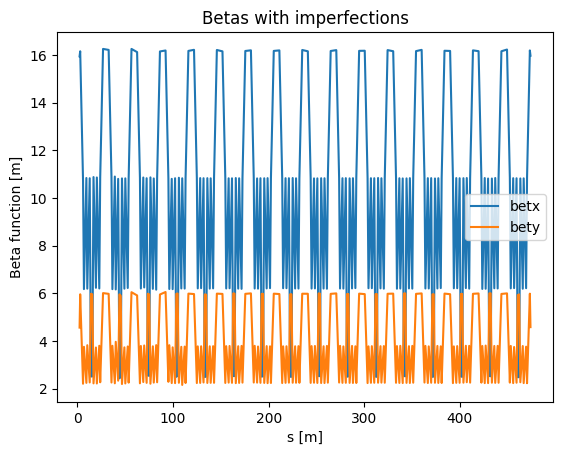

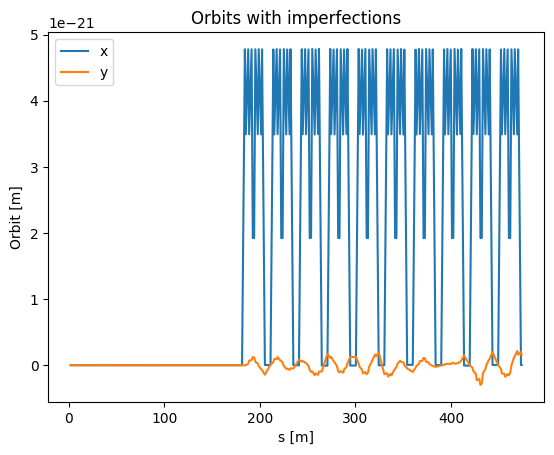

In [28]:
steps_for_matching = {"k1": 1e-3, "kick": 1e-4, "k1s": 1e-3}
interim_optics_nosext_matched = match_optics(structure_nosext, aligns=align_errs, target_vars=["betx", "bety"], target_optical_funcs=init_optics, elem_and_params_to_match=elems_for_matching, param_steps=steps_for_matching, 
                                             algorithms=["lmdif", "simplex"], file_with_kicks=None, verbose=True)
plot_optics(interim_optics_nosext_matched, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_nosext_matched, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

## Optics correction wih LOCO

In [44]:
params_to_vary = {"k1l": {"Knobs": {i: {"Elements": [i]} for i in quads}}}
steps = {"k1l": 1e-5}

lattice_correction = LatticeCorrection(structure_nosext,
                                       orm,
                                       tunes,
                                       params_to_vary,
                                       steps,
                                       imperfections=align_errs)
lattice_correction.prepare_for_fit()
lattice_correction.svd_jacobian()
lattice_correction.choose_singular_values(len(params_to_vary))
lattice_correction.invert_jacobian()

for i in range(5):
    lattice_correction.fit()

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 418.21it/s]


TwissFailed: 

In [ ]:
old_aligns = lattice_correction.current_imperfections
lattice_corrected_optics = get_optics(structure_nosext, aligns=align_errs, old_aligns=old_aligns)

plt.plot(lattice_corrected_optics["x"], label='x')
plt.plot(lattice_corrected_optics["y"], label='y')
plt.legend()
plt.show()

plt.plot(lattice_corrected_optics["betx"], label='betx')
plt.plot(lattice_corrected_optics["bety"], label='bety')
plt.legend()
plt.show()

# Optics with all kind imperfections, sextupoles on

In [12]:
interim_optics = get_optics(structure, align_errs)
plot_optics(interim_optics, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1939/1939 [00:04<00:00, 445.82it/s]


Twiss Failed!


TypeError: 'NoneType' object is not subscriptable

100%|█████████████████████████████████████████████████████████████████████▉| 500009/500130 [00:01<00:00, 378507.72it/s]
3it [00:00, 2928.30it/s]


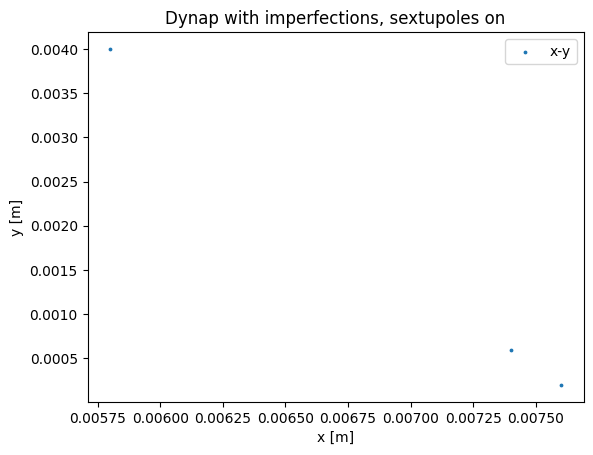

In [13]:
params = {"x": "m",
          "y": "m"}
tab_err = read_tracking_file("tracking_data/tracking_xy_norad_1000one.txt", unlost_only=True)
plot_dynap(tab_err, params, title="Dynap with imperfections, sextupoles on", plot_name="x-y")
plt.show()

# Optics with dxdydpsi imperfections, sextupoles off

In [14]:
align_errs = create_err_table(["dx", "dy", "dpsi"], elems_with_errs)

In [15]:
interim_optics_nosext = get_optics(structure_nosext, align_errs)
plot_optics(interim_optics_nosext, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_nosext, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1939/1939 [00:04<00:00, 439.78it/s]


Twiss Failed!


TypeError: 'NoneType' object is not subscriptable

 15%|██████████▍                                                          | 500009/3299507 [00:01<00:08, 314669.07it/s]
1it [00:00, ?it/s]


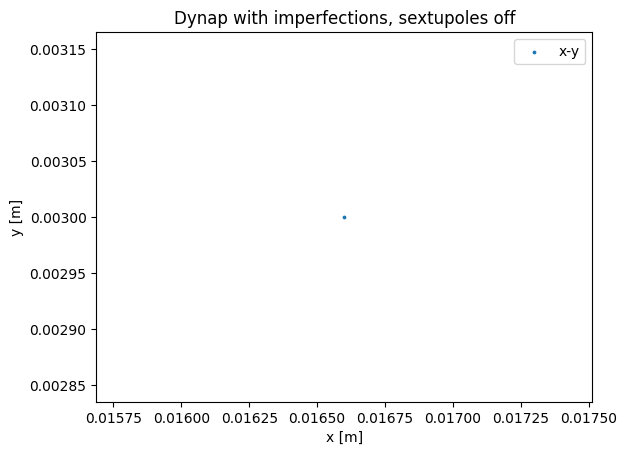

In [17]:
params = {"x": "m",
          "y": "m"}
tab_err = read_tracking_file("tracking_data/tracking_xy_nosext_norad_dxdydpsi_1000one.txt", unlost_only=True)
plot_dynap(tab_err, params, title="Dynap with imperfections, sextupoles off", plot_name="x-y")
plt.show()

# Optics with dxdydpsi imperfections, sextupoles on

In [18]:
interim_optics = get_optics(structure, align_errs)
plot_optics(interim_optics, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1939/1939 [00:04<00:00, 439.88it/s]


Twiss Failed!


TypeError: 'NoneType' object is not subscriptable

100%|█████████████████████████████████████████████████████████████████████▉| 500009/500209 [00:01<00:00, 404541.91it/s]
7it [00:00, 7000.51it/s]


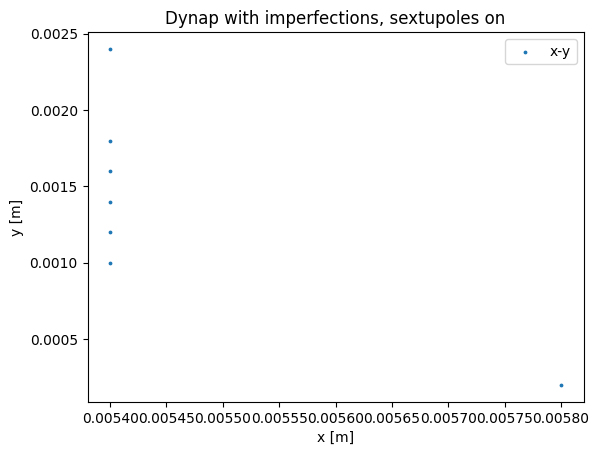

In [19]:
params = {"x": "m",
          "y": "m"}
tab_err = read_tracking_file("tracking_data/tracking_xy_norad_dxdydpsi_1000one.txt", unlost_only=True)
plot_dynap(tab_err, params, title="Dynap with imperfections, sextupoles on", plot_name="x-y")
plt.show()